In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!wget -O nn_Tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW1/classification/nn_Tools.py

--2022-07-05 10:17:17--  https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW1/classification/nn_Tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11946 (12K) [text/plain]
Saving to: ‘nn_Tools.py’

nn_Tools.py         100%[===================>]  11.67K  --.-KB/s    in 0s      

2022-07-05 10:17:17 (54.2 MB/s) - ‘nn_Tools.py’ saved [11946/11946]



In [3]:
!pip install -q optuna
!pip install -q -U kaleido
!pip install -q imgaug==0.2.6
!pip install -q --upgrade matplotlib

     |████████████████████████████████| 308 kB 7.1 MB/s 
     |████████████████████████████████| 81 kB 6.3 MB/s 
     |████████████████████████████████| 209 kB 100.7 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 112 kB 55.7 MB/s 
     |████████████████████████████████| 146 kB 71.8 MB/s 
     |████████████████████████████████| 79.9 MB 1.8 MB/s 
     |████████████████████████████████| 631 kB 7.4 MB/s 
     |████████████████████████████████| 11.2 MB 8.2 MB/s 
     |████████████████████████████████| 930 kB 86.4 MB/s 


In [1]:
import matplotlib.pyplot as plt
from plotly import express as px, graph_objects as go
from plotly.subplots import make_subplots
import os
import plotly.io as pio
import nn_Tools as nt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets

from sklearn.model_selection import RandomizedSearchCV

from math import ceil
from scipy.stats import randint
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import gc
import optuna

pio.kaleido.scope.mathjax = None
seed = 69420
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Define transformation on data: invert the colors of roughly p*100 % of the images.
transform = transforms.Compose([
        transforms.ToTensor()
        ]) 

full_set = datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)

split_prop = 0.8
evens = np.arange(len(full_set)*0, int(len(full_set)*0.8))
odds = np.arange(int(len(full_set)*0.8), len(full_set))

trainset_1 = Subset(full_set, evens)
trainset_2 = Subset(full_set, odds)

train_dataset, valid_dataset = random_split(full_set, [ceil(len(full_set)*split_prop), ceil(len(full_set)*(1-split_prop))])
test_dataset = datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

n_train = int(len(train_dataset)/3)
n_test = int(len(test_dataset))

split_idx = int(0.75*n_train)

trainloader1 = DataLoader(trainset_1, batch_size = 20, num_workers = 0)
trainloader2 = DataLoader(trainset_2, batch_size = 20, num_workers = 0)
train_dataloader = DataLoader(train_dataset, batch_size = 20, num_workers = 0)
val_dataloader = DataLoader(valid_dataset, batch_size = 20, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = 1, num_workers = 0)

sample_index = 125
image = train_dataset[sample_index][0].squeeze()
label = train_dataset[sample_index][1]


fig = px.imshow(image, color_continuous_scale='gray')#, cmap='Greys')
fig.update_layout(width=300, height=300, paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)',coloraxis_showscale=False,margin=dict(l=30, r=30, t=30, b=30))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

img_shape = tuple(image.shape)
no_labels = len(np.unique(full_set.targets))

if not os.path.exists("images"):
    os.mkdir("images")

fig.write_image(f"images/sample_MNIST.pdf", width=500, height=500)

SAMPLE AT INDEX 125
LABEL: 4


In [6]:
gc.collect()
torch.cuda.empty_cache()

num_epochs = 10

params = {
        'conv1': {'filters1': 24, 'k1': 6},
        'conv2': {'filters2': 56, 'k2': 2},
        'conv3': {'filters3': 128, 'k3': 3},
        'lin1' : 50,
        'lin2' : 100
        }

loss_fn_nb = nn.CrossEntropyLoss().to(device)
loss_fn_wb = nn.CrossEntropyLoss().to(device)

cnn_nobatch = nt.CNN2d(28, params, device, init_weight='normal')
cnn_batch = nt.CNN2d(28, params, device, init_weight='normal', batch_norm=True)

cnn_nobatch.to(device)
cnn_batch.to(device)

params_nb = [
    {'params' : cnn_nobatch.parameters()},
    ]
params_wb = [
    {'params' : cnn_batch.parameters()},
    ]

optim_nb = torch.optim.Adam(params_nb, lr=1e-4, weight_decay=1e-5)
optim_wb = torch.optim.Adam(params_wb, lr=1e-4, weight_decay=1e-5)

nt.train_model(
    cnn_nobatch, train_dataloader,val_dataloader,
    num_epochs, loss_fn_nb, optim_nb, verbose=True)
nt.train_model(
    cnn_batch, train_dataloader,val_dataloader,
    num_epochs, loss_fn_wb, optim_wb, verbose=True)

0.33520057797431946

In [7]:
no_batchnorm_df = pd.DataFrame(cnn_nobatch.history).melt(
    id_vars='epoch', var_name='loss_type', value_name='loss')
no_batchnorm_df['type'] = 'without_BatchN'

batchnorm_df = pd.DataFrame(cnn_batch.history).melt(
    id_vars='epoch', var_name='loss_type', value_name='loss')

batchnorm_df['type'] = 'with_BatchN'

combo_df = pd.concat([no_batchnorm_df, batchnorm_df])
fig = combo_df.plot(x='epoch', y='loss', color='loss_type', facet_col='type',
                    labels={"epoch": "Training epoch",
                            "loss": "Loss", "loss_type": "Dataset"}
                    )

fig.update_layout(title='Loss evolution',
                  margin=dict(l=10, r=10, t=60, b=10),
                  font=dict(size=18))

for i, title_str in enumerate(['Without batch normalization', 'With batch normalization']):
    fig.layout.annotations[i].text = title_str

fig.show()

if not os.path.exists("images"):
    os.mkdir("images")

fig.write_image(f"images/fig{i}.pdf", width=1000, height=500)

In [8]:
test_score_nb = cnn_nobatch.score(test_dataloader)
test_score_wb = cnn_batch.score(test_dataloader)

print(f"No batchnorm score: {test_score_nb}")
print(f"With batchnorm score: {test_score_wb}")

No batchnorm score: 0.9097
With batchnorm score: 0.8971


In [9]:
def CNN_objective(trial):
    """
    Performs a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """

    # Parameters in the search include number of filters, size of the first
    # dense layer, shape of latent space, optimizer type, and finally its 
    # respective learning rate.

    params = {
        'conv1': {'filters1': trial.suggest_int('filters1', 16, 32),
                  'k1': 3},
        'conv2': {'filters2': trial.suggest_int('filters2', 64, 128),
                  'k2': 3},
        'conv3': {'filters3': trial.suggest_int('filters3', 64, 128),
                  'k3': 3},
        'lin1' : trial.suggest_int('lin1', 32, 128),
        'lin2' : trial.suggest_int('lin2', 100, 200)
    }
    init_weights = trial.suggest_categorical("weight_init",
                                             ["uniform", "normal"])
    model = nt.CNN2d(28, params, device,
                     init_weight = init_weights, batch_norm=True)
    model.to(device)

    # Define the optimizer
    optim = getattr(
        torch.optim, trial.suggest_categorical(
            "optim", ["Adam", "SGD", "AdamW"]))(
                model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-2)
            )
    loss_fn = nn.CrossEntropyLoss()
    # Train and evaluate model
    val_loss = nt.train_model(model,
        trainloader2, test_dataloader,
        num_epochs=5, loss_fn=loss_fn, optimizer=optim, verbose=False
        )

    return val_loss

In [10]:
study = optuna.create_study(direction='minimize')
study.optimize(CNN_objective, n_trials=20)

[I 2022-07-05 10:23:40,636] A new study created in memory with name: no-name-d720b97c-4d78-490a-b9aa-4c8f066869c4
[I 2022-07-05 10:24:51,350] Trial 0 finished with value: 0.433149129152298 and parameters: {'filters1': 28, 'filters2': 103, 'filters3': 67, 'lin1': 73, 'lin2': 127, 'weight_init': 'normal', 'optim': 'Adam', 'lr': 1.0014136266694605e-05}. Best is trial 0 with value: 0.433149129152298.
[I 2022-07-05 10:26:04,395] Trial 1 finished with value: 0.4187757670879364 and parameters: {'filters1': 28, 'filters2': 116, 'filters3': 110, 'lin1': 60, 'lin2': 170, 'weight_init': 'uniform', 'optim': 'Adam', 'lr': 2.3916630600741312e-05}. Best is trial 1 with value: 0.4187757670879364.
[I 2022-07-05 10:27:16,193] Trial 2 finished with value: 0.8386095762252808 and parameters: {'filters1': 21, 'filters2': 76, 'filters3': 89, 'lin1': 41, 'lin2': 104, 'weight_init': 'normal', 'optim': 'AdamW', 'lr': 0.00022233500333718946}. Best is trial 1 with value: 0.4187757670879364.
[I 2022-07-05 10:28:28

In [11]:
study.best_params

{'filters1': 22,
 'filters2': 105,
 'filters3': 98,
 'lin1': 114,
 'lin2': 136,
 'lr': 0.004274363008843705,
 'optim': 'SGD',
 'weight_init': 'uniform'}

In [12]:
gc.collect()
torch.cuda.empty_cache()

best_params = {
    'conv1': {'filters1': study.best_params['filters1'],
                'k1': 3},
    'conv2': {'filters2': study.best_params['filters2'],
                'k2': 3},
    'conv3': {'filters3': study.best_params['filters3'],
                'k3': 3},
    'lin1' : study.best_params['lin1'],
    'lin2' : study.best_params['lin2']
}
classifier = nt.CNN2d(28, best_params, device,
                   init_weight=study.best_params['weight_init'], batch_norm=True)
classifier.to(device)

optim = getattr(torch.optim, study.best_params['optim'])(
    classifier.parameters(), lr=study.best_params['lr'],
    weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()

val_loss = nt.train_model(classifier, train_dataloader, val_dataloader, 30, loss_fn, optim)
test_score = classifier.score(test_dataloader)
print(f"\nModel correctly classified {test_score*100:.2f}% of the test set.")


[9999/10000] >>> Accuracy score: 0.92010
Model correctly classified 92.01% of the test set.


In [13]:
torch.save(classifier, 'best_model.pt')

In [3]:
cnn = torch.load('best_model.pt')
cnn.device = device
cnn.to(device)

# cnn.score(test_dataloader)

CNN2d(
  (features): Sequential(
    (0): Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(22, 105, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(105, 98, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=43218, out_features=114, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropo

1


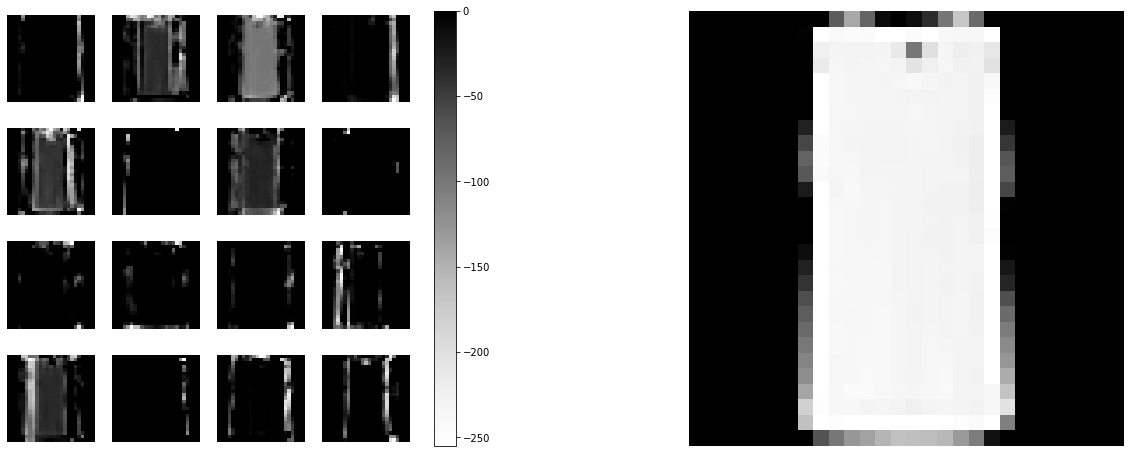

In [4]:
cnn_iter = cnn.children()
def get_layer_output(input_img, model, layer_ord, device):
    model_iter = model.children()
    out_img = input_img.unsqueeze(0).unsqueeze(0).to(device)
    for i in range(layer_ord+1):
        out_img = next(model_iter)(out_img)

    return out_img.squeeze(0).cpu().detach().numpy()



feat_part = next(cnn_iter)
seq_part = next(cnn_iter)

index0 = test_dataset.targets == 0
index6 = test_dataset.targets == 6

#Find misclassified sample
shirts = test_dataset.data[index0].float()
for i, img in enumerate(shirts):
    model_out = torch.argmax(cnn.predict(img.unsqueeze(0).unsqueeze(0).to(device))).item()
    if (model_out == 6):
        print(i)
        break

rand_img = test_dataset.data[index0][i].float()
out_img = get_layer_output(rand_img, feat_part, 5, device)


fig = plt.figure(figsize=(18,8))
subfigs = fig.subfigures(1,2)

left_axs = subfigs[0].subplots(4, 4)
for ax, out in zip(left_axs.flatten(), out_img):
    ax.imshow(-out, cmap='Greys')
    ax.axis('off')

right_axs = subfigs[1].subplots(1,1)
sample_filter = right_axs.imshow(-rand_img, cmap='Greys')
right_axs.axis('off')

cbar = fig.colorbar(sample_filter, ax=left_axs, location="right")
fig.show()

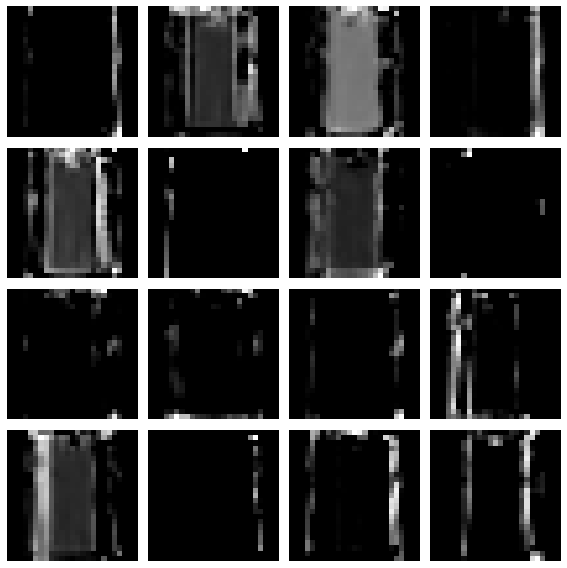

In [5]:
fig, axs = plt.subplots(4,4, figsize=(8,8), tight_layout='pad')
for ax, out in zip(axs.flatten(), out_img):
    ax.imshow(-out, cmap='Greys')
    ax.axis('off')

fig.savefig('receptive_1.pdf')

In [6]:
label_pred = torch.zeros(len(test_dataloader)).to(device)
for i, sample_batch in enumerate(test_dataloader):
    x = sample_batch[0].to(device)
    label_pred[i] = torch.argmax(cnn.predict(x), dim=1).item()

In [ ]:
true_labels = test_dataloader.dataset.targets

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(true_labels, label_pred.cpu().numpy())
cleaned_confmat = np.copy(conf_mat)
for i, diag_elem in enumerate(np.diag(conf_mat)):
    cleaned_confmat[i,i] -= diag_elem
fig = plt.figure(figsize=(11,9))
conf_plot = sns.heatmap(conf_mat, fmt='d', annot=True, cmap='Blues', annot_kws={"fontsize":16})
fig.add_subplot(conf_plot)

fig.savefig('images/confusion_matrix.pdf')

In [ ]:
weight_arri = [layer._parameters['weight'].cpu().detach().numpy() for layer in seq_part if type(layer) == torch.nn.modules.linear.Linear]


In [24]:
weight_arri[-3].shape

torch.Size([4926852])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:376: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:376: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:376: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:376: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:376: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/

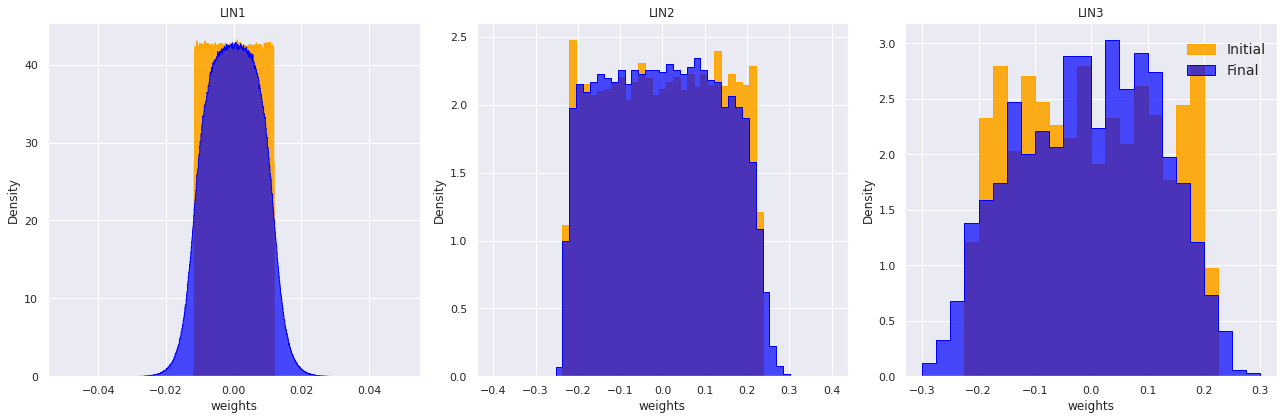

In [83]:
%matplotlib inline
import seaborn as sns
sns.set_theme()
cnn.reset_model()
cnn_iter = cnn.children()
feat_part = next(cnn_iter)
seq_part = next(cnn_iter)

datamin = [-0.05, -0.4, -0.3]
datamax = [0.05, 0.4, 0.3]
numbins = [800, 50, 25]


weight_arri = [
    layer._parameters['weight'].cpu().ravel()
    for layer in seq_part
    if type(layer) == torch.nn.modules.linear.Linear
    ]

mybins = [torch.linspace(dmin, dmax, nbins) 
    for dmin, dmax, nbins in zip(datamin, datamax, numbins)]

fig, axs = plt.subplots(1,len(weight_arri), figsize=(18, 6), tight_layout='pad')

for i, (ax, weights, bins) in enumerate(zip(axs, weight_arri, mybins)):
    counts, bs = torch.histogram(weights, bins=bins)
    df = pd.DataFrame(data={'counts': counts.detach().numpy(),
                            'weights' : bs.detach().numpy()[:-1]})
    sns.histplot(data=df,
            x='weights',
            weights='counts',
            bins=bs.detach().numpy(),
            alpha=0.9,
            stat='density',
            ax=ax,
            color='orange',
            label='Initial',
            element='step')
    ax.set_title(f'LIN{i+1}')


cnn = torch.load('best_model.pt')
cnn_iter = cnn.children()
feat_part = next(cnn_iter)
seq_part = next(cnn_iter)

weight_arrf = [
    layer._parameters['weight'].cpu().ravel()
    for layer in seq_part
    if type(layer) == torch.nn.modules.linear.Linear]

for i, (ax, weights, bins) in enumerate(zip(axs, weight_arrf, mybins)):
    counts, bs = torch.histogram(weights, bins=bins)
    df = pd.DataFrame(data={'counts': counts.detach().numpy(),
                            'weights' : bs.detach().numpy()[:-1]})
    sns.histplot(data=df,
            x='weights',
            weights='counts',
            bins=bs.detach().numpy(),
            alpha=.7,
            stat='density',
            ax=ax,
            color='blue',
            label='Final',
            element='step')
    ax.set_title(f'LIN{i+1}')


# fig, axs = plt.subplots(1, len(weight_arri), figsize=(16,7), tight_layout='pad')
# for ax, arri, arrf, bins in zip(axs, weight_arri, weight_arrf, mybins):
#     counts, bins, _ = ax.hist(arri, bins=bins, alpha=0.9, label='Initial weights', density=True)
#     counts, bins, _ = ax.hist(arrf, bins=bins, alpha=0.5, label='Trained weights', density=True)



# axs.hist(bins.detach().numpy()[:-1], weights=counts.detach().numpy(), bins=bins.detach().numpy()[:-1])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(.92,.8), fontsize=14, frameon=False, )
fig.show()
# fig.savefig('images/weight_evo.pdf')

In [84]:
fig.savefig('images/weight_hists.pdf')

In [85]:
weight_arri[-1].detach().numpy()

array([-0.1621519 , -0.01003501, -0.06159965, ...,  0.0858817 ,
        0.1618789 , -0.0233944 ], dtype=float32)

In [1]:
cnn.reset_model()
cnn_iter = cnn.children()
feat_part = next(cnn_iter)
seq_part = next(cnn_iter)

weight_arri = [layer._parameters['weight'].cpu().detach().numpy() for layer in seq_part if type(layer) == torch.nn.modules.linear.Linear]


cnn = torch.load('best_model.pt')
cnn_iter = cnn.children()
feat_part = next(cnn_iter)
seq_part = next(cnn_iter)

weight_arrf = [layer._parameters['weight'].cpu().detach().numpy() for layer in seq_part if type(layer) == torch.nn.modules.linear.Linear]


fig, axs = plt.subplots(1, 1, figsize=(16,7), tight_layout='pad')

datamin = -0.2
datamax = 0.2
numbins = 5000
mybins = np.array([np.linspace(datamin, datamax, numbins) for i in range(len(weight_arri))])

axs.hist(weight_arri[0], bins=mybins, density=True)
axs.hist(weight_arrf[0], bins=mybins, density=True)


SyntaxError: ignored

In [ ]:
test_conv = cnn.state_dict()['features.0.weight'][0].squeeze(0).squeeze(0).numpy()

fig1, axs1 = plt.subplots(5,cnn.state_dict()['features.0.weight'].shape[0]//4, figsize=(16, 8))
for i, conv_filter in enumerate(cnn.state_dict()['features.0.weight']):
    plot_filter = conv_filter.squeeze(0).squeeze(0).numpy()
    axs1.flatten()[i].imshow(plot_filter, cmap='gray')
    axs1.flatten()[i].axis('off')

In [ ]:
fig2, axs2 = plt.subplots(*tuple(cnn.state_dict()['features.4.weight'].size()[:2][::-1]), figsize = (16, 14))

plot_ct = 0
for filters in cnn.state_dict()['features.4.weight']:
    for conv_filter in filters:
        plot_filter = conv_filter.cpu().detach().numpy()
        axs2.flatten()[plot_ct].imshow(plot_filter, cmap='gray')
        axs2.flatten()[plot_ct].axis("off")
        plot_ct+=1

In [ ]:
plot_filter

In [ ]:
cnn.state_dict()['model.3.weight'].shape

In [ ]:
layer1 = cnn.state_dict()['model.0.weight']
layer1.shape[0]

In [ ]:
X_val = full_set.data
y_val = full_set.targets

X_val = X_val.unsqueeze(1).type('torch.FloatTensor')

In [ ]:
params = {
    'lr' : [0.1, 0.01, 0.001],
    'max_epochs' : [30, 50, 80],
    'module__conv1_filters' : randint(2, 6),
    'module__k_size1' : randint(2, 5),
    'module__conv2_filters' : randint(2, 8),
    'module__k_size2' : randint(2, 4),
    'module__Nd1' : randint(10, 25),
    'module__Nd2' :randint(8, 20),
    'optimizer' : [optim.Adam, optim.Adagrad, optim.SGD]
    }

grid_search = RandomizedSearchCV(net, params, refit = False, n_iter = 6, cv = 4, scoring = 'neg_log_loss', error_score = 'raise')

grid_search.fit(X_val, y_val)

print(grid_search.best_score_, grid_search.best_params_)

In [ ]:
net.history[:, ('train_loss', 'valid_loss')]

plt.plot(range(net.max_epochs), net.history[:, 'train_loss'])
plt.plot(range(net.max_epochs), net.history[:, 'valid_loss'])

In [ ]:
cnn = torch.load('CNN_model.pt')

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 0)
test_accuracy = cnn.accuracy(test_dataloader)
print(f"Accuracy on test set: {test_accuracy*100:.3f}%")

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')

